# Procesamiento Adaptativo de Señales Aleatorias
# Trabajo Práctico N°2 - Filtro óptimo
## Grupo 3
* Santiago Arribere
* Matías Francois
* Joaquín Gaytan
* Pablo Scheinfeld

# 1. Señales de prueba
Se buscará medir la respuesta impulsiva de una habitación empleando las siguientes señales de prueba.

* Señal de voz
* Señal de música
* Señal rectangular ($f=100Hz$)
* Barrido lineal de frecuencia ($f_0=20Hz$, $f_1=20kHz$)
* Barrido exponencial de frecuencia ($f_0=20Hz$, $f_1=20kHz$)
* Ruido blanco gaussiano ($\mu_N = 0$)

Cada una de estas señales tendrá una duración de diez segundos.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sps
from IPython.display import Audio
from scipy.io import wavfile
from scipy import linalg, hamming
from scipy.fft import fft, fftfreq
from time import time as pytime

In [2]:
base = '..'
record_base = base + '/assets/recorded_sounds/wav/'
original_base = base + '/assets/test_signals/'
audios_dict = {
    # AudioType: (recorded, original)
    #'song': ('music_wav.wav','darkside_mono_cortado.wav'),
    'voice': ('where-i-am_wav.wav','whereIam441_cortado.wav'),
    'linear sweep': ('linear-este-es-posta-10seg.wav','linear_sweep.wav'),
    'periodic linear sweep': ('multiple-linear_wav.wav','linear_sweep_periodic.wav'),
    'exp sweep': ('exp_sweep_joaco.wav','exp_sweep.wav'),
    'periodic exp sweep': ('multiple-exponential_wav.wav','exp_sweep_periodic.wav'),
    'square': ('rectangular_wav.wav','rectangular.wav'),
    'wgn': ('white-noise_wav.wav','white_noise.wav')
}

In [3]:
# base = '../assets/prestado'
# record_base = base + '/recorded/'
# original_base = base + '/original/'
# audios_dict = {
#     # AudioType: (recorded, original)
#     'song': ('lorde.wav','lorde.wav'),
#     'voice': ('sofunny.wav','sofunny.wav'),
#     'linear sweep': ('sweeplin.wav','sweeplin.wav'),
#     #'periodic linear sweep': ('multiple-linear_wav.wav','linear_sweep_periodic.wav'),
#     'exp sweep': ('sweeplog.wav','sweeplog.wav'),
#     #'periodic exp sweep': ('multiple-exponential_wav.wav','exp_sweep_periodic.wav'),
#     'square': ('cuadrada.wav','cuadrada.wav'),
#     #'wgn': ('ruido.wav','ruido.wav')
# }

In [4]:
# Define samplerate for input signals
samplerate = 44100 # Hz

# Define track length
tracklen = 10 # sec

In [5]:
def print_signal(x, y, title, samplerate=None, color='blue', xlim=None, window='hann', ylim=None):
    fig, axs = plt.subplots(2, 1, figsize=(25,10))
    fig.suptitle(title, fontsize=20)
    
    # Time plot
    axs[0].grid()
    axs[0].set_xlabel('Time [sec]')
    if (xlim != None):
        if (len(xlim) == 2):
            axs[0].set_xlim(xlim[0],xlim[1])
    axs[0].plot(x, y, color=color)
            
    # Spectrogram plot
    if samplerate != None:
        f, t, Sxx = sps.spectrogram(y, samplerate, window=window, nperseg=256, noverlap=64)
        axs[1].set_ylabel('Frequency [Hz]')
        axs[1].set_xlabel('Time [sec]')
        if (ylim != None):
            if (len(ylim) == 2):
                axs[1].set_ylim(ylim[0],ylim[1])
        axs[1].pcolormesh(t, f, Sxx, shading='gouraud')

In [6]:
# Assuming that response is delayed from the original. (Add exception!)
#
def sync_tracks(_original, response, scurity=500):
    print('entro a sinc tracks')
    if len(_original) > len(response):
        raise Exception('Response needs to be larger than original signal!')

    diff = len(response)-len(_original)
    # Original signal padding
    original = np.concatenate((_original, np.zeros(diff)))

    # Compute cross-correlation
    xcorr = sps.correlate(response / np.max(response), original / np.max(original), method='fft')

    # Calculate which lag to apply to sync signals
    sync_lag = np.abs((len(xcorr) // 2) - np.argmax(np.abs(xcorr))) - scurity
    print('Salgo de sinc traacks')
    return original, np.concatenate((response[sync_lag:], np.zeros(sync_lag)))

# Probando con sweep exponencial periódico

In [7]:
rate, original = wavfile.read(original_base + audios_dict['periodic exp sweep'][1])
rate, record = wavfile.read(record_base + audios_dict['periodic exp sweep'][0])

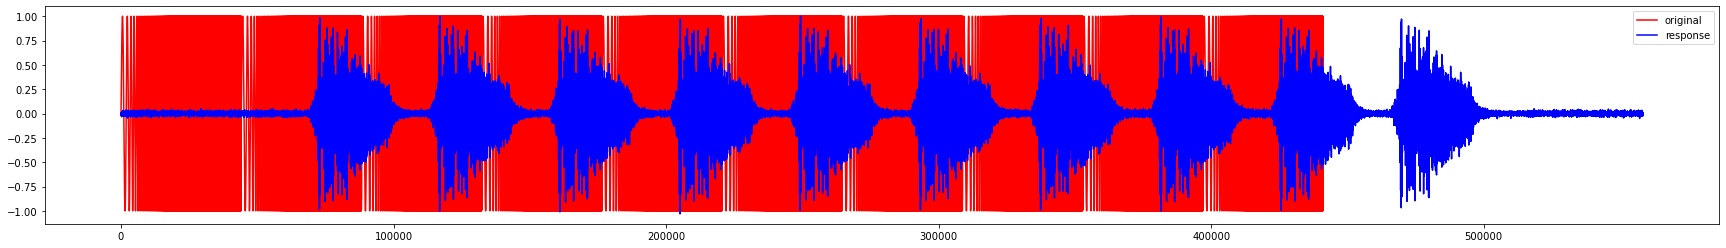

In [8]:
plt.figure(figsize=(30,4))
plt.plot(original/np.max(original), color='red', label='original')
plt.plot(record/np.max(record), color='blue', label='response')
plt.legend()
plt.show()

In [9]:
# sync tracks
original_shifted, response_shifted = sync_tracks(original, record)

entro a sinc tracks
Salgo de sinc traacks


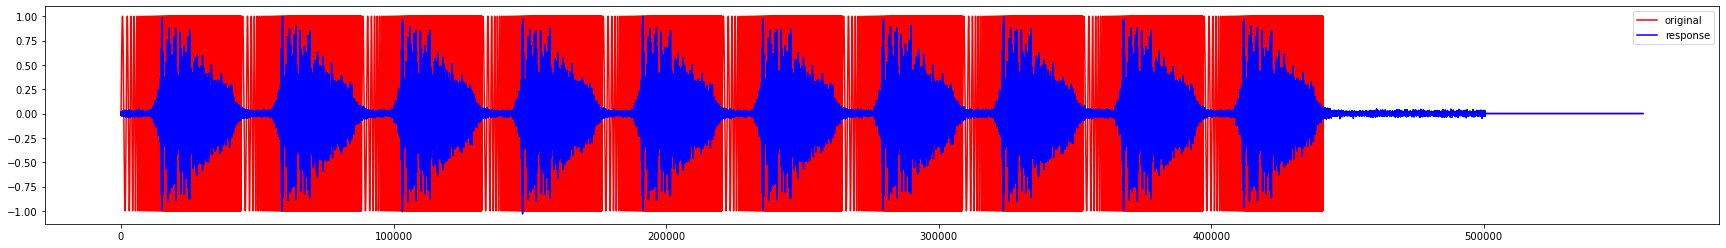

In [10]:
plt.figure(figsize=(30,4))
plt.plot(original_shifted/np.max(original_shifted), color='red', label='original')
plt.plot(response_shifted/np.max(response_shifted), color='blue', label='response')
plt.legend()
plt.show()

# Filtro óptimo

In [11]:
# Nuestras funciones 
def get_r_p(original, recorded):
    print('Empiezo a correlacionar')
    N = len(original)
    # Calculate r (autocorrelation vector)
    r = sps.correlate(original, original, method='fft',mode='same')[N//2:] / N
    print('Listo r')
    # Calculate p (cross-correlation vector) - Assuming both signals real and same size
    
    p = sps.correlate(recorded, original, mode='same') / N
    print('algo raro')
    p = np.flip(p[:N//2])
    
    s2d = np.var(recorded)
    print('salgo')
    return r,p,s2d

def get_filter(r, p, M, sigma):
    r_ = r[:M]
    p_ = p[:M]
    print('Magia para resolver toplis')
    wo = linalg.solve_toeplitz(r, p, check_finite=False)
    print('termino la magia')
    jo = sigma - p_.dot(wo)
    return wo, p_, jo, jo/sigma

In [12]:
# Funciones de Ari
#Función en la que para una entrada u y una deseada d se estiman la autocorrealción rx de u, la cruzada entre u y d y la varianza de la señal deseada
def get_estimations(u,d):
    u_f = np.fft.fft(u)
    d_f = np.fft.fft(d)
    
    ##Estimo rx
    r = np.fft.ifft(u_f * u_f.conj()).real
    r = r[:len(u)//2]/len(u)
    ##Estimo p
    p = np.fft.ifft(u_f * d_f.conj()).real
    p = p[len(u)//2:]/len(u)
    p = np.flip(p)

    ##Estimo la energia de d
    s2d = np.var(d)
    return r,p,s2d

#Habiendo obtenido rx,p y la varianza de la señal deseada, para un M dado se obtienen los coeficientes del filtro óptimo y el valor de Jmin asociado
def get_filter_v2(rx,p,M,sigma2d):
    rx1=rx[0:M]
    p1=p[0:M]
    # R = toeplitz(rx1)
    # se obtienen los coeficientes wo
    wo = linalg.solve_toeplitz(rx1, p1, check_finite=False)# np.dot(linalg.inv(R), p1)
    Jmin = sigma2d - p1.dot(wo)
    return wo,p1,Jmin,Jmin/sigma2d


### Test

In [160]:
def get_r_p(original, record):
    o_f = np.fft.fft(original)
    r_f = np.fft.fft(record)
    
    ##Estimo rx
    r = np.fft.ifft(o_f * o_f.conj()).real
    r = r[:len(original)//2]/len(original)
    ##Estimo p
    p = np.fft.ifft(o_f * r_f.conj()).real
    p = p[len(original)//2:]/len(original)
    p = np.flip(p)

    ##Estimo la energia de d
    s2d = np.var(recorded)
    return r,p,s2d

def get_r_p_v2(original, record):
    N = len(original)
    # Calculate r (autocorrelation vector)
    r = sps.correlate(original, original, method='fft',mode='same')[N//2:] / N
    
    # Calculate p (cross-correlation vector) - Assuming both signals real and same size
    p = sps.correlate( recorded, original, method='fft', mode='same') / N
    p = np.flip(p)
    s2d = np.var(record)
    return r,p,s2d

In [161]:
o_rate, original = wavfile.read(original_base + audios_dict['song'][1])
r_rate, recorded = wavfile.read(record_base + audios_dict['song'][0])
# print(original.shape, recorded.shape)
if len(original.shape) == 2:
    original = original[:,0]

if len(recorded.shape) == 2:
    recorded = np.concatenate((recorded[:,0],np.zeros(len(original)-len(recorded))))
else:
    recorded = np.concatenate((recorded,np.zeros(len(original)-len(recorded))))
# Aling both signals
original_shifted, response_shifted = sync_tracks(original, recorded)
r1, p1, s1 = get_r_p(original_shifted, response_shifted)
r2, p2, s2 = get_r_p_v2(original_shifted, response_shifted)

(297675,) (297675,)
(595350,) (297675,)


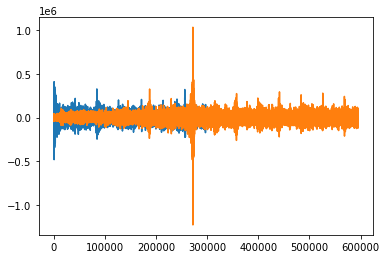

In [162]:
print(p1.shape, r1.shape)
print(p2.shape, r2.shape)
plt.plot(p1)
plt.plot(p2)


In [163]:
# # Both signals with same size
# def get_filter(original, recorded, M, GPU=False):
#     if len(original) != len(recorded):
#         raise Exception('Both arrays must have same size!')

# #     # R.w0 = p => w0 = R^-1 . p
# #     N = len(original)

# #     # Calculate r (autocorrelation vector)
# #     r = sps.correlate(original, original, method='fft')[:N-1] / N
# #     r = r[:M+1]
# #     # Calculate p (cross-correlation vector) - Assuming both signals real and same size
# #     p = sps.correlate(recorded, original, method='fft')[N-1:] / N
# #     p = np.flip(p)[:M+1]
#     r, p, s = get_r_p(original, recorded)
#     r = r[:M]
#     p = p[:M]
#     if GPU:
#         # Generate autocorrelation matrix
#         R = linalg.toeplitz(r)

#         # Allocate GPU memory for R
#         R_gpu = gpuarray.to_gpu(R)
#         Rinv_gpu = qlinalg.inv(R_gpu, overwrite=True)

#         # Allocate GPU memory for p
#         p_gpu = gpuarray.to_gpu(np.transpose(p))

#         # Compute coefficients
#         wo_gpu = qlinalg.dot(Rinv_gpu, p_gpu)
#         wo = wo_gpu.get()

#     else:
#         wo = linalg.solve_toeplitz(r, p, check_finite=False)

#     return wo, p

# def get_filter_v2(rx,p,M,sigma2d):
#     rx1=rx[0:M]
#     p1=p[0:M]
#     R = toeplitz(rx1)
#     # se obtienen los coeficientes wo
#     wo = np.dot(linalg.inv(R), p1)
#     Jmin = sigma2d - p1.dot(wo)
#     return p1,wo,Jmin

# def error_v2(p, wo, sigma):
#     jmin = sigma - p.dot(wo)
#     return jmin, jmin/sigma

In [164]:
def errors(p, w0, sigma2):
    jo = sigma2 - np.dot(p,w0)
    epsilon = jo/sigma2
    return jo, epsilon

# Prueba con todas las pistas

In [13]:
# Get best M for linear sweep
order = [(i*(10**j)) for j in range(1,4) for i in range(1,10)] + [10000, 12500, 20000]
#order = [1,2]
errors_dict = {}
best = {'epsilon':1, 'type': None, 'order':None}
for k in audios_dict:
    print('inicio ', k)
    jo, epsilon  = [], []
    # Get audio files
    o_rate, original = wavfile.read(original_base + audios_dict[k][1])
    r_rate, recorded = wavfile.read(record_base + audios_dict[k][0])
    
    # Aling both signals
    original_shifted, response_shifted = sync_tracks(original, recorded)
    
    u = original_shifted #- np.mean(original_shifted)
    d = response_shifted #- np.mean(response_shifted)
    
    # Cosas Cosas Cosas
    u_f = np.fft.fft(u)
    d_f = np.fft.fft(d)
    print('hago fft')
    ##Estimo rx
    r = np.fft.ifft(u_f * u_f.conj()).real
    r = r[:len(u)//2]/len(u)
    print('inversa r')
    ##Estimo p
    p = np.fft.ifft(u_f * d_f.conj()).real
    p = p[len(u)//2:]/len(u)
    p = np.flip(p)
    print('p calculo')
    ##Estimo la energia de d
    s2d = np.var(d)
    print('varianza')
    r,p,s2d
    # Fin de Cosas Cosas Cosas
    #r, p, sigma = get_estimations(original_shifted, response_shifted)
    
    # Get the variance of the desier signal
    for i in order:
        print(i)
        wo,p1, j, e  = get_filter(r, p, i, s2d)
        jo.append(j)
        epsilon.append(e)
        if best['epsilon'] > e:
            best['epsilon'] = e
            best['type'] = k
            best['order'] = i

    errors_dict[k] = {'jo':jo, 'epsilon':epsilon}
    print(f'Fin {k}')

inicio  voice
entro a sinc tracks
Salgo de sinc traacks
hago fft
inversa r
p calculo
varianza
10
Magia para resolver toplis
termino la magia


ValueError: shapes (10,) and (290397,) not aligned: 10 (dim 0) != 290397 (dim 0)

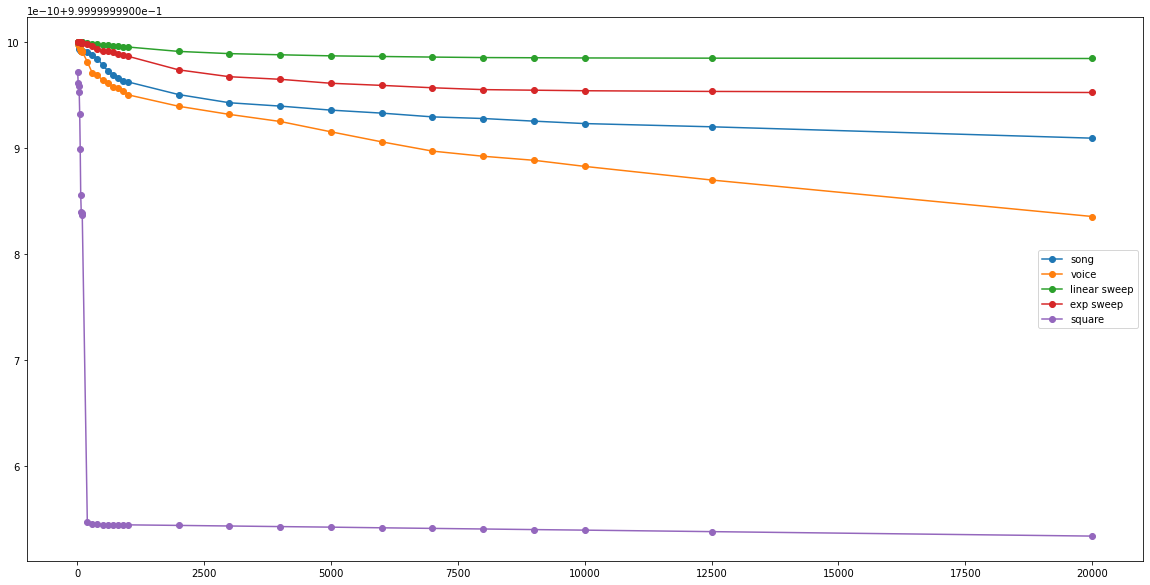

In [168]:
plt.figure(figsize=(20,10))
for k in errors_dict:
    ep = errors_dict[k]['epsilon']
    plt.plot(order, ep, label=k, marker='o')
plt.legend()

In [77]:
# Get best M for linear sweep
lin_order = [(i*(10**j)) for j in range(1,4) for i in range(1,10)] + [10000, 12500, 20000]

# Open signal
o_rate, original = wavfile.read(original_base + audios_dict['linear sweep'][1])
r_rate, recorded = wavfile.read(record_base + audios_dict['linear sweep'][0])

# Align both signals
original_shifted, response_shifted = sync_tracks(original, recorded)

# Create empty lists
eps = []
elapsed = []

# Compute desired signal variance
sigma2 = np.var(response_shifted)

for M in lin_order:
    start = pytime()
    wo, p = get_filter(original_shifted, response_shifted, M)
    end = pytime()
    t = end - start
    elapsed.append(t)
    jo, e = errors(p, wo, sigma2)
    eps.append(e)

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_13948/4210178309.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  o_rate, original = wavfile.read(original_base + audios_dict['linear sweep'][1])


Exception: Response needs to be larger than original signal!

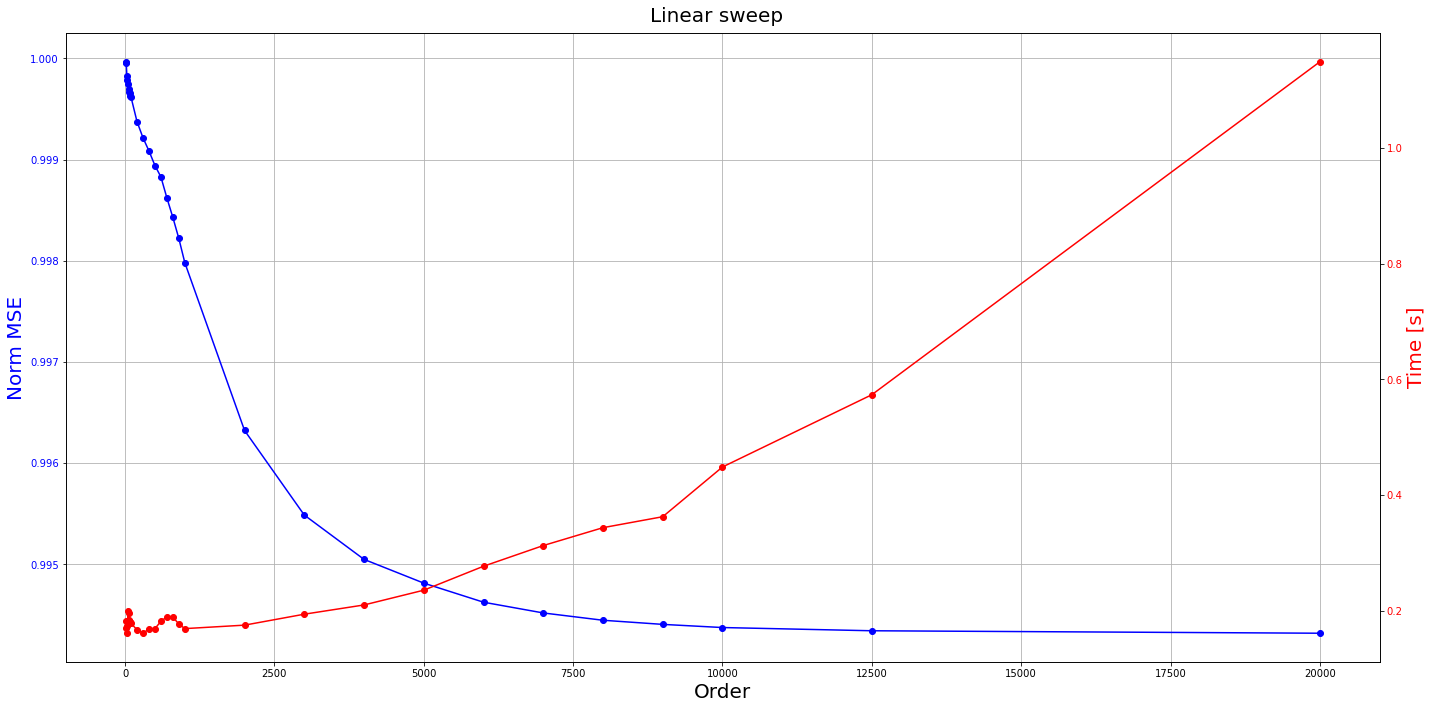

In [34]:
fig, ax1 = plt.subplots(figsize=(20,10))
fig.suptitle('Linear sweep', fontsize=20)

# Plot error
ax1.plot(lin_order, eps, marker='o', color='blue')
ax1.set_ylabel('Norm MSE', fontsize=20, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(which='both', axis='both')
ax1.set_xlabel('Order', fontsize=20)

# Plot elapsed time
ax2 = ax1.twinx()
ax2.plot(lin_order, elapsed, marker='o', color='red')
ax2.set_ylabel('Time [s]', fontsize=20, color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()

# Prueba de filtro con dos señales iguales

In [38]:
# Get audio files
o_rate, original = wavfile.read(original_base + audios_dict[best['type']][1])
r_rate, recorded = wavfile.read(record_base + audios_dict[best['type']][0])
# Aling both signals
original_shifted, response_shifted = sync_tracks(original, recorded)

# Get the variance of the desier signal
sigma2 = np.var(response_shifted)
wo, p = get_filter(np.concatenate((original_shifted,np.zeros(1000))), np.concatenate((np.zeros(1000),original_shifted)), 10000)

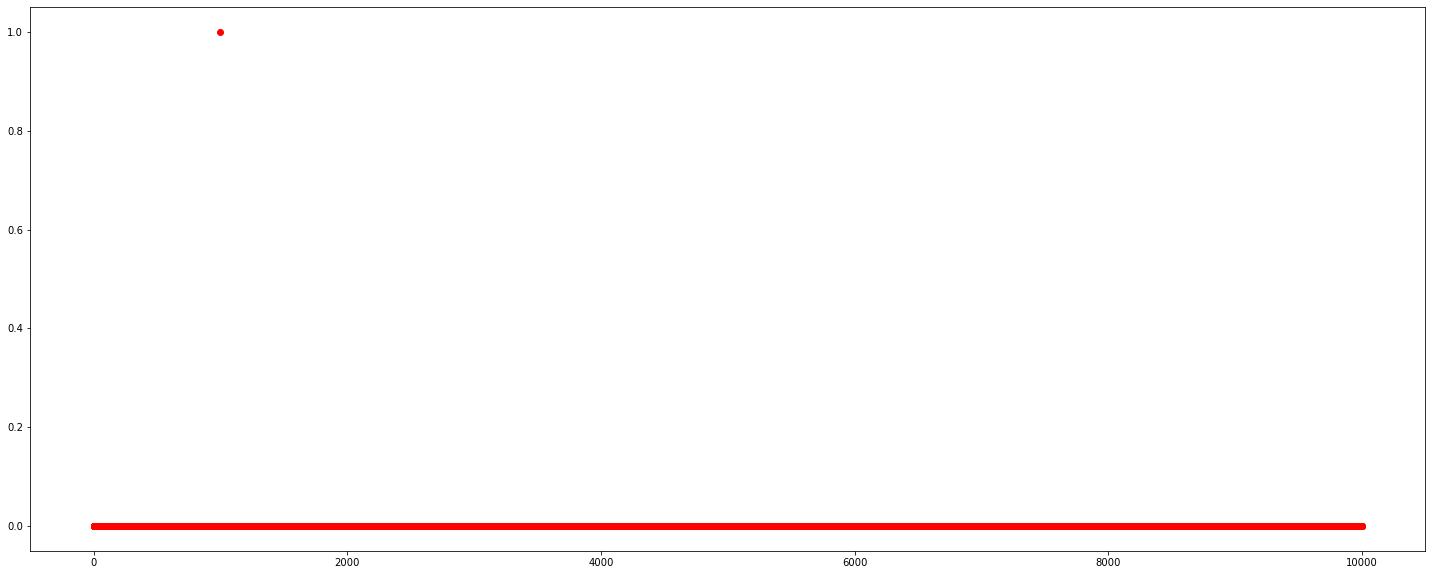

In [39]:
plt.figure(figsize=(25,10))
plt.scatter(np.arange(len(wo)), wo, color='red')

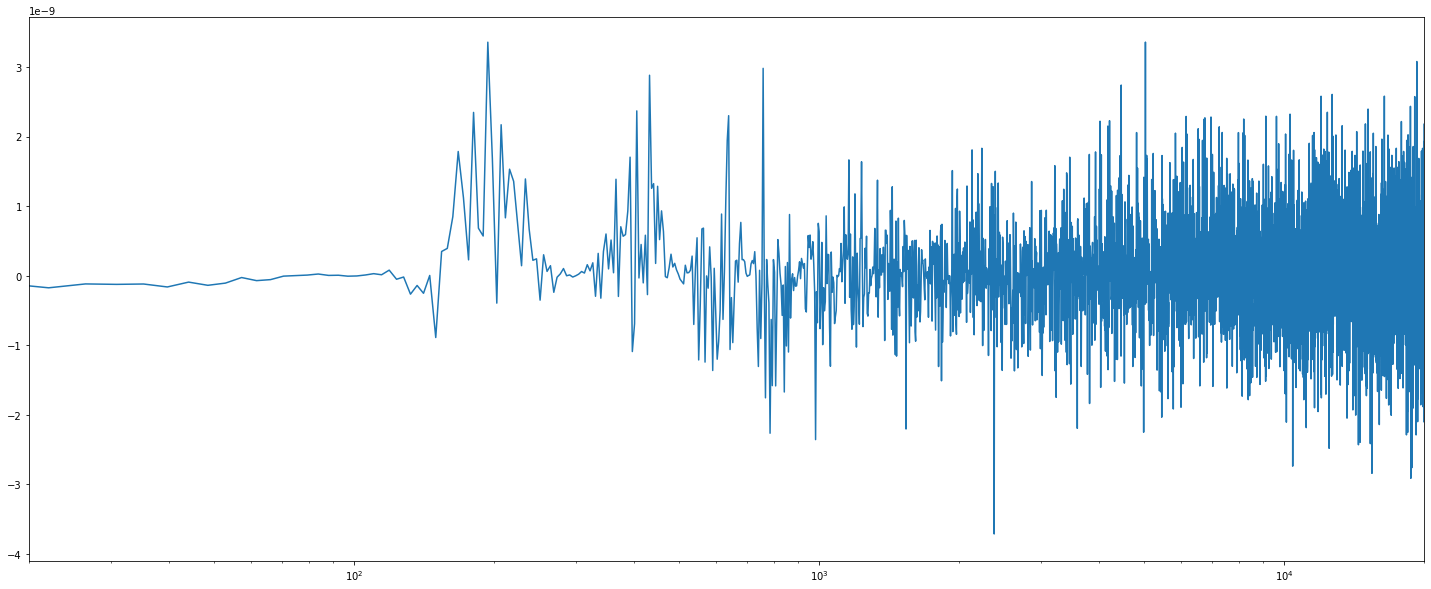

In [40]:
plt.figure(figsize=(25,10))
spect = fft(wo)
freq = fftfreq(len(wo), 1/samplerate)
plt.semilogx()
plt.xlim(20,20000)
plt.plot(freq[freq>0], 20*np.log(np.abs(spect[freq>0])))

In [50]:
o_rate, original = wavfile.read(original_base + audios_dict['song'][1])
audio_filtered = sps.oaconvolve(original, wo)
# Generate WAV file
output = to_wav(audio_filtered/32767, o_rate, base + '/assets/output/song_convolve.wav', scale=1)
# Play WAV file
Audio(base + '/assets/output/song_convolve.wav')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


In [51]:
audio_filtered.max()

32767.000000000007

In [52]:
o_rate, response = wavfile.read(record_base + audios_dict['song'][0])

In [53]:
response.max()
Audio(record_base + audios_dict['song'][0])

## Comparación espectrogramas

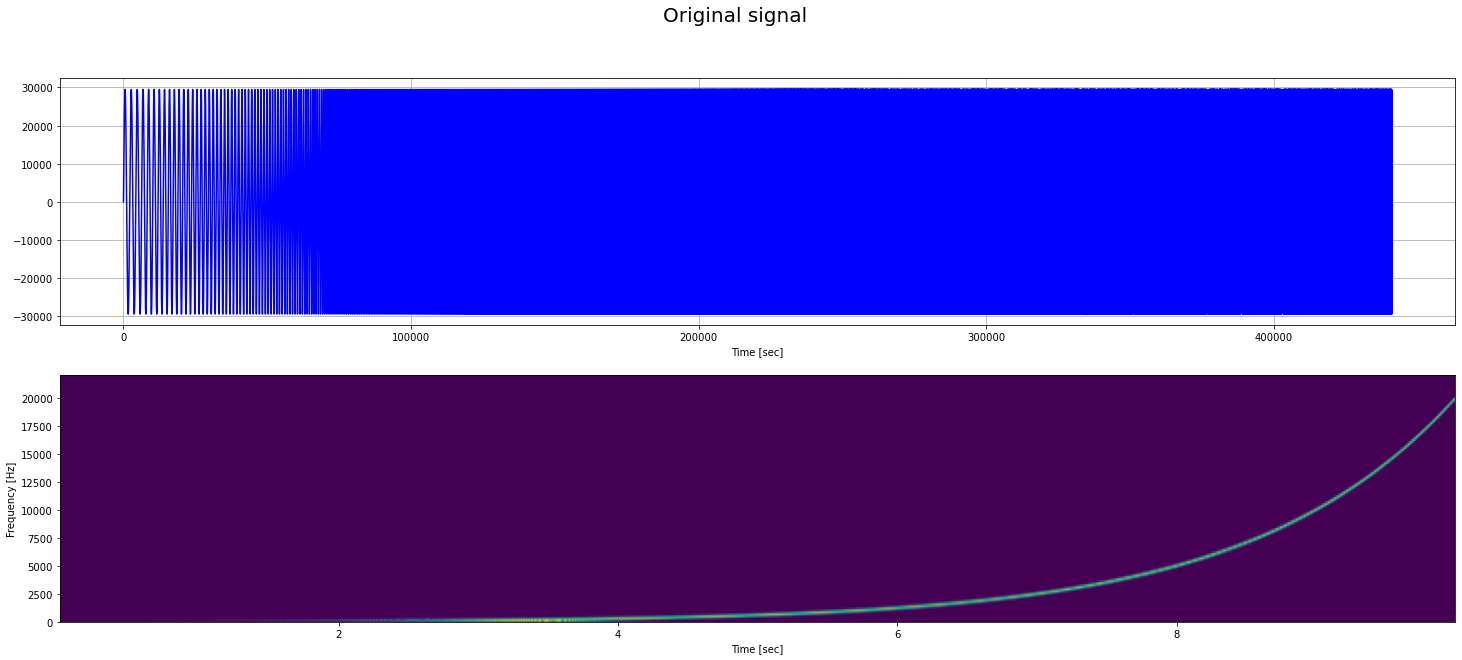

In [46]:
k = 'exp sweep'
f_o, y_o = wavfile.read(original_base + audios_dict[k][1])
f_r, y_r = wavfile.read(record_base + audios_dict[k][0])
y_r = y_r*2

print_signal(np.arange(len(y_o)), y_o, 'Original signal' , samplerate=f_o)

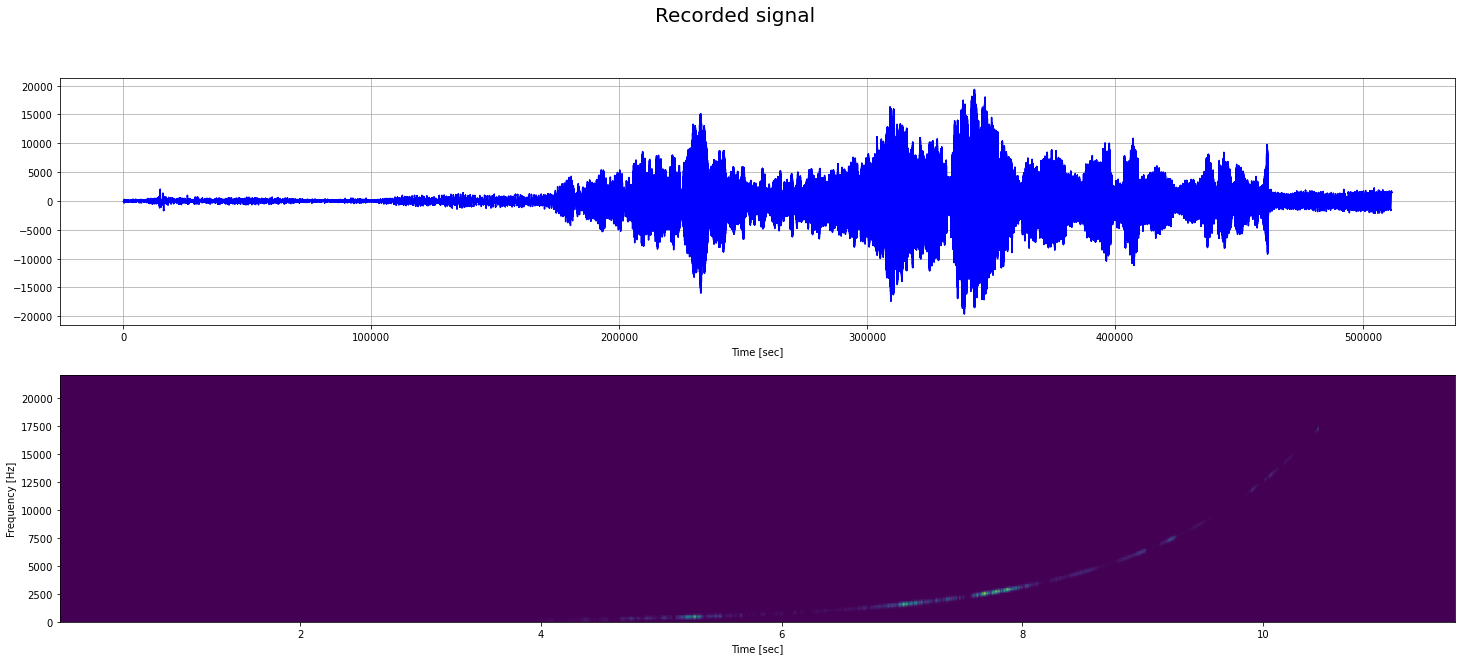

In [47]:
print_signal(np.arange(len(y_r)), y_r, 'Recorded signal' , samplerate=f_r)

In [48]:
Audio(record_base + audios_dict[k][0])